# Open session and import packages

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('project_churn').getOrCreate()

In [2]:
from pyspark.sql.types import *
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Suppress all warnings
warnings.filterwarnings("ignore")

# Import data

In [3]:
# import train set
train = spark.read.csv('train.csv', header = True)
# import test set
test = spark.read.csv('test.csv', header = True)

# Data Format

In [4]:
train.show(truncate = False)

+---+----------+--------------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
|id |CustomerId|Surname       |CreditScore|Geography|Gender|Age |Tenure|Balance  |NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---+----------+--------------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
|0  |15674932  |Okwudilichukwu|668        |France   |Male  |33.0|3     |0.0      |2            |1.0      |0.0           |181449.97      |0     |
|1  |15749177  |Okwudiliolisa |627        |France   |Male  |33.0|1     |0.0      |2            |1.0      |1.0           |49503.5        |0     |
|2  |15694510  |Hsueh         |678        |France   |Male  |40.0|10    |0.0      |2            |1.0      |0.0           |184866.69      |0     |
|3  |15741417  |Kao           |581        |France   |Male  |34.0|2     |148882.54|1            |1.0      |1.0           |84560.88 

In [5]:
# visualize all features type
train.printSchema()

root
 |-- id: string (nullable = true)
 |-- CustomerId: string (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: string (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Tenure: string (nullable = true)
 |-- Balance: string (nullable = true)
 |-- NumOfProducts: string (nullable = true)
 |-- HasCrCard: string (nullable = true)
 |-- IsActiveMember: string (nullable = true)
 |-- EstimatedSalary: string (nullable = true)
 |-- Exited: string (nullable = true)



In [6]:
# removing features that don't serve any purpose
train = train.drop('id','surname')

In [7]:
# rename all to lower case letters, feature and data, and removing all blank spaces
for col in train.columns:
    train = train.withColumn(col, F.lower(F.col(col)))
    train = train.withColumn(col, F.trim(F.col(col)))
    train = train.withColumnRenamed(col, col.lower())

In [8]:
# visualize how the feature data are arranged
train.show(5, truncate = False)

+----------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
|customerid|creditscore|geography|gender|age |tenure|balance  |numofproducts|hascrcard|isactivemember|estimatedsalary|exited|
+----------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
|15674932  |668        |france   |male  |33.0|3     |0.0      |2            |1.0      |0.0           |181449.97      |0     |
|15749177  |627        |france   |male  |33.0|1     |0.0      |2            |1.0      |1.0           |49503.5        |0     |
|15694510  |678        |france   |male  |40.0|10    |0.0      |2            |1.0      |0.0           |184866.69      |0     |
|15741417  |581        |france   |male  |34.0|2     |148882.54|1            |1.0      |1.0           |84560.88       |0     |
|15766172  |716        |spain    |male  |33.0|5     |0.0      |2            |1.0      |1.0           |15068.83       |

In [9]:
# changing data types to numeric type
int_columns = ['tenure', 'balance', 'estimatedsalary']

for col in int_columns:
    train = train.withColumn(col, F.col(col).cast(FloatType()))

int_columns = ['creditscore', 'age', 'numofproducts', 'hascrcard', 'isactivemember', 'exited']
for col in int_columns:
    train = train.withColumn(col, F.col(col).cast(IntegerType()))
    

In [10]:
train.printSchema()

root
 |-- customerid: string (nullable = true)
 |-- creditscore: integer (nullable = true)
 |-- geography: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- tenure: float (nullable = true)
 |-- balance: float (nullable = true)
 |-- numofproducts: integer (nullable = true)
 |-- hascrcard: integer (nullable = true)
 |-- isactivemember: integer (nullable = true)
 |-- estimatedsalary: float (nullable = true)
 |-- exited: integer (nullable = true)



# Exploratory Data Analysis

In [11]:
train.summary().show()

+-------+--------------------+----------------+---------+------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+
|summary|          customerid|     creditscore|geography|gender|              age|            tenure|           balance|     numofproducts|         hascrcard|     isactivemember|   estimatedsalary|             exited|
+-------+--------------------+----------------+---------+------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+
|  count|              165034|          165034|   165034|165034|           165034|            165034|            165034|            165034|            165034|             165034|            165034|             165034|
|   mean|1.5692005019026382E7|656.454373038283|     NULL|  NULL|38.12588315135063| 5.020353381727402| 55478.08669040132|1.554455

In [12]:
def eda_basic(df, cols:list):
    # lista auxiliar para adicionar os registros
    summary_data = []
    
    for feature in cols:
        # retirada de espaços vazios nos valores das colunas
        trimmed_col = df.withColumn(feature, F.trim(F.col(feature)))
        # cálculo de registros únicos
        unique_values = df.select(feature).distinct().count()
        # cálculo do total de registros
        total_values = df.count()
        # cálculo da porcentagem de missings nas features
        percent_missings = (df.select(feature).where(f'{feature} == "None" or {feature} == "" ').count()/total_values)*100
        # adiciona os valores calculados a um registro referente à respectiva feature
        summary_data.append((feature, unique_values, total_values, percent_missings))
        
    # criação do Dataframe de saída
    df = spark.createDataFrame(summary_data, ["feature", "unique_value", "total_values", "percent_missing"])
    
    return df

In [13]:
eda = eda_basic(train, train.columns[1:])

In [14]:
eda.show()

+---------------+------------+------------+---------------+
|        feature|unique_value|total_values|percent_missing|
+---------------+------------+------------+---------------+
|    creditscore|         457|      165034|            0.0|
|      geography|           3|      165034|            0.0|
|         gender|           2|      165034|            0.0|
|            age|          69|      165034|            0.0|
|         tenure|          11|      165034|            0.0|
|        balance|       29807|      165034|            0.0|
|  numofproducts|           4|      165034|            0.0|
|      hascrcard|           2|      165034|            0.0|
| isactivemember|           2|      165034|            0.0|
|estimatedsalary|       54502|      165034|            0.0|
|         exited|           2|      165034|            0.0|
+---------------+------------+------------+---------------+



Train set dont have any missing data in features, so we need to looking for outliers and know if they are possible or not to consider and how we can work with him.

In [15]:
# visualizing percentile in each feature to know about outliers in data
percentile_data_pandas = train.select("age", "tenure", "balance", "numofproducts", "estimatedsalary").summary('95%', '96%', '97%', '98%', '99%', 'max').toPandas().T.reset_index()
percentile_data_pandas.columns = percentile_data_pandas.iloc[0]
percentile_data_pandas = percentile_data_pandas[1:]
percentile_data_pandas = percentile_data_pandas.reset_index(drop=True)

df_percentile = spark.createDataFrame(percentile_data_pandas)
df_percentile.show()

+---------------+---------+---------+---------+---------+---------+---------+
|        summary|      95%|      96%|      97%|      98%|      99%|      max|
+---------------+---------+---------+---------+---------+---------+---------+
|            age|       56|       57|       59|       62|       66|       92|
|         tenure|      9.0|      9.0|     10.0|     10.0|     10.0|     10.0|
|        balance|151657.81|153949.69|158623.03|164880.31|172274.02| 250898.1|
|  numofproducts|        2|        2|        2|        3|        3|        4|
|estimatedsalary|183487.98|184872.66|187756.23|190347.72|196111.34|199992.48|
+---------------+---------+---------+---------+---------+---------+---------+



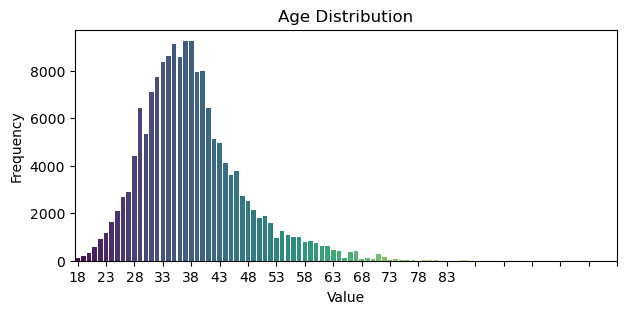

In [16]:
# construct graphics about information to visualize how the data are distributed
distribution_feature = train.select("Age").groupBy("Age").count()

pd_distribution_feature = distribution_feature.toPandas()

plt.figure(figsize=(7, 3))
sns.barplot(data=pd_distribution_feature, x="Age", y="count", palette="viridis")
plt.xticks(np.arange(0, pd_distribution_feature["Age"].max()+5, 5))
plt.title("Age Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [17]:
# verifying label balancing
train.select("exited").groupby("exited").count().show()

+------+------+
|exited| count|
+------+------+
|     1| 34921|
|     0|130113|
+------+------+



# Data Wrangling

In [18]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# transforming category variables in category index, its because to use OneHotEncoder we need a index not a category
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(train) for column in ["geography", "gender"]]

# Aplying OneHotEncoder to transform catergory index in dummys
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_encoded") for column in ["geography", "gender"]]

# create pipeline to transform category variables in dummys
pipeline = Pipeline(stages=indexers+encoders)
data = pipeline.fit(train).transform(train)

In [19]:
data.show()

+----------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+-----------------+--------------+
|customerid|creditscore|geography|gender|age|tenure|  balance|numofproducts|hascrcard|isactivemember|estimatedsalary|exited|geography_index|gender_index|geography_encoded|gender_encoded|
+----------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+-----------------+--------------+
|  15674932|        668|   france|  male| 33|   3.0|      0.0|            2|        1|             0|      181449.97|     0|            0.0|         0.0|    (2,[0],[1.0])| (1,[0],[1.0])|
|  15749177|        627|   france|  male| 33|   1.0|      0.0|            2|        1|             1|        49503.5|     0|            0.0|         0.0|    (2,[0],[1.0])| (1,[0],[1.0])|
|  15694510|        678|   france|  male| 40|  10.0|      0.0|   

In [20]:
from pyspark.ml.feature import VectorAssembler

# select relevant features
feature_columns = ["creditscore", "age", "tenure", "balance", "numofproducts", "hascrcard",
                   "isactivemember", "estimatedsalary", "geography_encoded", "gender_encoded"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

In [21]:
from pyspark.ml.feature import StandardScaler

# standard features using standard scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

In [22]:
data.show(5)

+----------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+-----------------+--------------+--------------------+--------------------+
|customerid|creditscore|geography|gender|age|tenure|  balance|numofproducts|hascrcard|isactivemember|estimatedsalary|exited|geography_index|gender_index|geography_encoded|gender_encoded|            features|     scaled_features|
+----------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+-----------------+--------------+--------------------+--------------------+
|  15674932|        668|   france|  male| 33|   3.0|      0.0|            2|        1|             0|      181449.97|     0|            0.0|         0.0|    (2,[0],[1.0])| (1,[0],[1.0])|[668.0,33.0,3.0,0...|[8.33922775176802...|
|  15749177|        627|   france|  male| 33|   1.0|      0.0|            2|        

In [23]:
train_data, test_data = data.randomSplit([0.8,0.2], seed=1)
#train_data.write.mode("overwrite").parquet("datas/train_data_model.parquet")
#test_data.write.mode("overwrite").parquet("datas/test_data_model.parquet")

# Models

In [24]:
#train_data = spark.read.parquet("datas/train_data_model")
#test_data = spark.read.parquet("datas/test_data_model")

In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [26]:
# Fuction to evaluate models
def evaluate_model(model, test_data):
    predictions = model.transform(test_data)

    # Binary evaluator(ROC-AUC and AUC-PR)
    evaluator_auc = BinaryClassificationEvaluator(labelCol="exited", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    evaluator_aucpr = BinaryClassificationEvaluator(labelCol="exited", rawPredictionCol="rawPrediction", metricName="areaUnderPR")

    auc = evaluator_auc.evaluate(predictions)
    aucpr = evaluator_aucpr.evaluate(predictions)

    # Multiclass evaluator(Accuracy, Precision,, Recall, F1-Score)
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="exited", predictionCol="prediction", metricName="accuracy")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="exited", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="exited", predictionCol="prediction", metricName="weightedRecall")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="exited", predictionCol="prediction", metricName="f1")

    accuracy = evaluator_accuracy.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    # Display results
    print(f"ROC-AUC: {auc:.3f}")
    print(f"AUC-PR: {aucpr:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")

In [27]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier, LinearSVC, NaiveBayes

In [28]:
# Logistic Regression Model
lr = LogisticRegression(featuresCol="scaled_features", labelCol="exited")
lr_model = lr.fit(train_data)

In [29]:
# Random Forest Classifier Model
rfc = RandomForestClassifier(featuresCol="scaled_features", labelCol="exited", seed=1)
rfc_model = rfc.fit(train_data)

In [30]:
# Gradient Boost Tree Classifier Model
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="exited", seed=1)
gbt_model = gbt.fit(train_data)

In [31]:
# Extreme Gradient Boost Model
# defining Neural Network archteture ([n features, hidden layers, output])
layers = [train_data.select("scaled_features").first()[0].size, 50, 2]

mlp = MultilayerPerceptronClassifier(featuresCol="scaled_features", labelCol="exited", layers=layers, maxIter=100, seed=1)
mlp_model = mlp.fit(train_data)

In [32]:
# Support Vector Machine Model
svc = LinearSVC(featuresCol="scaled_features", labelCol="exited", maxIter=100)
svc_model = svc.fit(train_data)

In [33]:
# Naive Bayes
nb = NaiveBayes(featuresCol="scaled_features", labelCol="exited")
nb_model = nb.fit(train_data)

In [34]:
# Analyzing models performance
print("#==============================#")
print("Logistic Regression")
evaluate_model(lr_model, test_data)
print("#==============================#")

print("Random Forest")
evaluate_model(rfc_model, test_data)
print("#==============================#")
    
print("Gradient Boost Tree")
evaluate_model(gbt_model, test_data)
print("#==============================#")

print("Multilayer Perceptron")
evaluate_model(mlp_model, test_data)
print("#==============================#")

print("Support Vector Machine")
evaluate_model(svc_model, test_data)
print("#==============================#")

print("Naive Bayes")
evaluate_model(nb_model, test_data)
print("#==============================#")

#==============================#
Logistic Regression
ROC-AUC: 0.814
AUC-PR: 0.586
Accuracy: 0.832
Precision: 0.816
Recall: 0.832
F1-Score: 0.812
#==============================#
Random Forest
ROC-AUC: 0.871
AUC-PR: 0.693
Accuracy: 0.852
Precision: 0.844
Recall: 0.852
F1-Score: 0.835
#==============================#
Gradient Boost Tree
ROC-AUC: 0.885
AUC-PR: 0.724
Accuracy: 0.862
Precision: 0.853
Recall: 0.862
F1-Score: 0.852
#==============================#
Multilayer Perceptron
ROC-AUC: 0.878
AUC-PR: 0.700
Accuracy: 0.859
Precision: 0.850
Recall: 0.859
F1-Score: 0.850
#==============================#
Support Vector Machine
ROC-AUC: 0.812
AUC-PR: 0.589
Accuracy: 0.833
Precision: 0.820
Recall: 0.833
F1-Score: 0.808
#==============================#
Naive Bayes
ROC-AUC: 0.641
AUC-PR: 0.322
Accuracy: 0.805
Precision: 0.780
Recall: 0.805
F1-Score: 0.759
#==============================#


# Model Optimization

In [35]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Setting GridSearch
param_grid = ParamGridBuilder().addGrid(gbt.maxIter, [10, 50, 100]) \
                                .addGrid(gbt.maxDepth, [1, 10, 20]) \
                                .addGrid(gbt.stepSize, [0.2, 0.1, 0.01]) \
                                .build()

In [ ]:
# Setting CrossValidator
evaluator = BinaryClassificationEvaluator(labelCol="exited", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
crossval = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)
cv_model = crossval.fit(train_data)

In [ ]:
# select best model in perfomance (AUCPR as metric)
gbt_best_model = cv_model.bestModel

In [ ]:
# Analyzing best model selected
print("Metrics to best model: ")
evaluate_model(gbt_model, test_data)

In [ ]:
# Saving model
gbt_best_model.write().overwrite().save("gbt_model_churn")

# Results

# Conclusion